In [26]:

import random
import cv2
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


# def get_mean_std_per_batch(image_path, df, H=320, W=320):
#     sample_data = []
#     for idx, img in enumerate(df.sample(100)["Image"].values):
#         # path = image_dir + img
#         sample_data.append(
#             np.array(image.load_img(image_path, target_size=(H, W))))

#     mean = np.mean(sample_data[0])
#     std = np.std(sample_data[0])
#     return mean, std


# def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
#     """Load and preprocess image."""
#     img_path = image_dir + img
#     mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
#     x = image.load_img(img_path, target_size=(H, W))
#     if preprocess:
#         # Convert image to numpy array
#         x = image.img_to_array(x)

#         # Histogram Equalization
#         x = cv2.cvtColor(x.astype('uint8'), cv2.COLOR_BGR2GRAY)
#         x = cv2.equalizeHist(x)

#         # Contrast Increase
#         alpha = 1.5  # Contrast factor
#         x = cv2.convertScaleAbs(x, alpha=alpha, beta=0)
    
#         x -= mean
#         x /= std
#         x = np.expand_dims(x, axis=0)
#     return x


# def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
#     """GradCAM method for visualizing input saliency."""
#     y_c = input_model.output[0, cls]
#     conv_output = input_model.get_layer(layer_name).output
#     grads = K.gradients(y_c, conv_output)[0]

#     gradient_function = K.function([input_model.input], [conv_output, grads])

#     output, grads_val = gradient_function([image])
#     output, grads_val = output[0, :], grads_val[0, :, :, :]

#     weights = np.mean(grads_val, axis=(0, 1))
#     cam = np.dot(output, weights)

#     # Process CAM
#     cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
#     cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
#     return cam


# def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
#                     layer_name='bn'):
#     preprocessed_input = load_image(img, image_dir, df)
#     predictions = model.predict(preprocessed_input)

#     print("Loading original image")
#     plt.figure(figsize=(15, 10))
#     plt.subplot(151)
#     plt.title("Original")
#     plt.axis('off')
#     plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

#     j = 1
#     for i in range(len(labels)):
#         if labels[i] in selected_labels:
#             print(f"Generating gradcam for class {labels[i]}")
#             gradcam = grad_cam(model, preprocessed_input, i, layer_name)
#             plt.subplot(151 + j)
#             plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
#             plt.axis('off')
#             plt.imshow(load_image(img, image_dir, df, preprocess=False),
#                        cmap='gray')
#             plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
#             j += 1


def get_roc_curve(labels, predicted_vals, generator, when = ''):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [27]:

# !pip install -q efficientnet
# import efficientnet.tfkeras as efn
!pip install seaborn


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model

from keras.models import load_model


# from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
import tensorflow.keras.layers as L
# import tensorflow.keras.layers as Layers

In [28]:
from tensorflow.keras.optimizers import Adam

In [29]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [30]:
IMAGE_SIZE=[128, 128]
EPOCHS = 40
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 64

print(BATCH_SIZE)

64


<a name='2'></a>
## 2. Load the Datasets

For this assignment, we will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

In [31]:
train_df_main = pd.read_csv('../input/chestxray8-dataframe/train_df.csv')
# valid_df = pd.read_csv("nih/valid-small.csv")
# test_df = pd.read_csv("nih/test.csv")

train_df_main.drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main.columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [32]:
from sklearn.model_selection import train_test_split
train_df, discard = train_test_split(train_df_main, test_size = 0.7, random_state = 1993)

train_and_valid_set, test_set = train_test_split(train_df, test_size = 0.2, random_state = 1993)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = 1993)

In [33]:
train_set

,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
10840,00002825_011.png,2825,0,0,0,0,0,0,0,0,1,0,0,0,0,0,../input/data/images_002/images/00002825_011.png
73618,00018163_000.png,18163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_008/images/00018163_000.png
87077,00021565_001.png,21565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_010/images/00021565_001.png
62793,00015564_006.png,15564,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_007/images/00015564_006.png
104989,00028256_005.png,28256,0,0,0,0,0,0,0,0,1,0,0,0,0,0,../input/data/images_012/images/00028256_005.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77893,00019176_020.png,19176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_009/images/00019176_020.png
56857,00014167_001.png,14167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_007/images/00014167_001.png
54106,00013633_003.png,13633,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_006/images/00013633_003.png
54590,00013685_056.png,13685,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_006/images/00013685_056.png


<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

<a name='Ex-1'></a>
### Exercise 1 - Checking Data Leakage
In the cell below, write a function to check whether there is leakage between two datasets. We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

In [34]:

def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0 
    return leakage

<a name='2-2'></a>
### 2.2 Preparing Images
With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Keras documentation, we have implemented the generator for you. There are a few things to note: 
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be **320px by 320px

In [35]:
import cv2
import numpy as np
import tensorflow_addons as tfa

def tf_equalize_histogram(image):
    values_range = tf.constant([0., 255.], dtype=tf.float32)
    
    # Convert image to float32 using tf.cast
    image_float = tf.cast(image, dtype=tf.float32)
    
    histogram = tf.histogram_fixed_width(image_float, values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.cast(cdf - cdf_min, dtype=tf.float32) * 255. / tf.cast(pix_cnt - 1, dtype=tf.float32))
    
    px_map = tf.cast(px_map, dtype=tf.uint8)

    # Use tf.gather to map values from px_map to the image
    eq_hist_img = tf.gather(px_map, tf.cast(image_float, dtype=tf.int32))

    return eq_hist_img

def preprocess_image(img):
#     img = img / 255.0
    img = tfa.image.equalize(img)
    img = tf.image.adjust_contrast(img, contrast_factor=1.5)
    img = tf.cast(img, dtype=tf.float32)

    return img


In [36]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """   
    # Custom preprocessing function
    def custom_preprocessing(image):
        image = preprocess_image(image)
        return image
    
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        rescale=1./255,
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect',
        preprocessing_function=custom_preprocessing  # Add custom preprocessing
    )
    
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

#### Build a separate generator for valid and test sets

Now we need to build a new generator for validation and testing data. 

**Why can't we use the same generator as for the training data?**

Look back at the generator we wrote for the training data. 
- It normalizes each image **per batch**, meaning that it uses batch statistics. 
- We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). 
- Knowing the average per batch of test data would effectively give our model an advantage.  
    - The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics **computed from the training set**. 
* We implement this in the function below. 
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. 
* However, since this is extremely large, that would be very time consuming. 
* In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [37]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="FilePath", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [38]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = None, 
                                      x_col = "FilePath",
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set, 
                                                              test_df = test_set, 
                                                              train_df = train_set,
                                                              image_dir = None, 
                                                              x_col = "FilePath", 
                                                              y_cols = labels,
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0], 
                                                              target_h = IMAGE_SIZE[1])

getting train generator...
Found 21476 validated image filenames.
getting train and valid generators...
Found 21476 validated image filenames.
Found 5370 validated image filenames.
Found 6712 validated image filenames.


<a name='2-3'></a>
### 2.3 Visualizing Images

Let's write a small function `get_label()` that will produce the class of the image as the appended string of the labels.

100%|██████████| 8/8 [00:00<00:00, 48.20it/s]


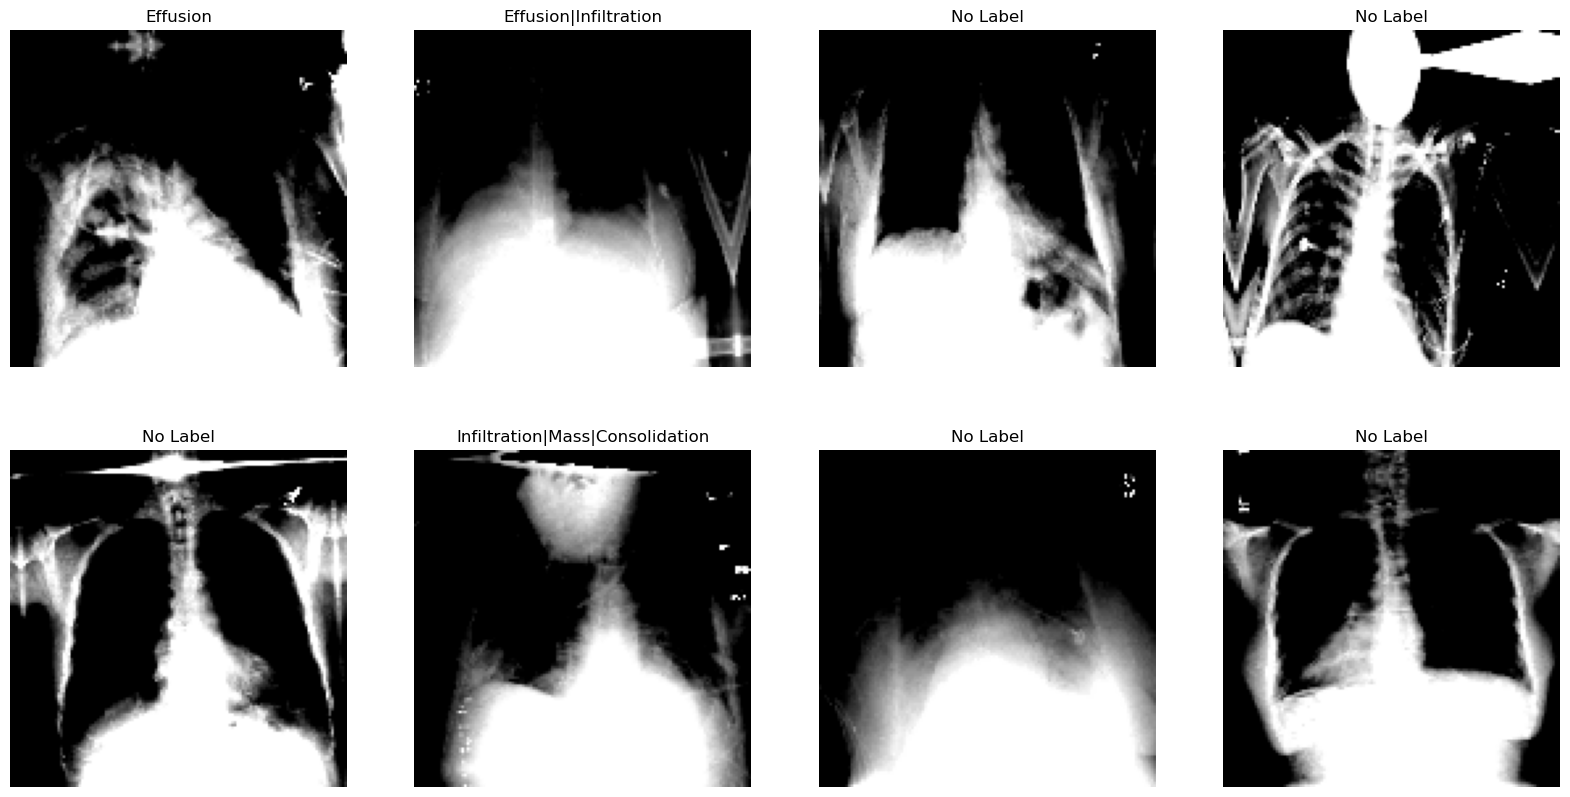

In [39]:

def get_label(y):
    """
    Returns the appended label list of the given set. 
    
    y(list) the one hot vector list containing the label encoding. 
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

#get one batch of images from the imageset    
x, y = train_generator.__getitem__(0)



#show a set of images along with the labels appended at the top as title.
fig=plt.figure(figsize=(20, 10))
columns = 4; rows =2 
for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i-1], cmap = 'gray')
    plt.title(get_label(y[i-1]))
    plt.axis(False)
    fig.add_subplot

<a name='3'></a>
## 3. Class Imbalence

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

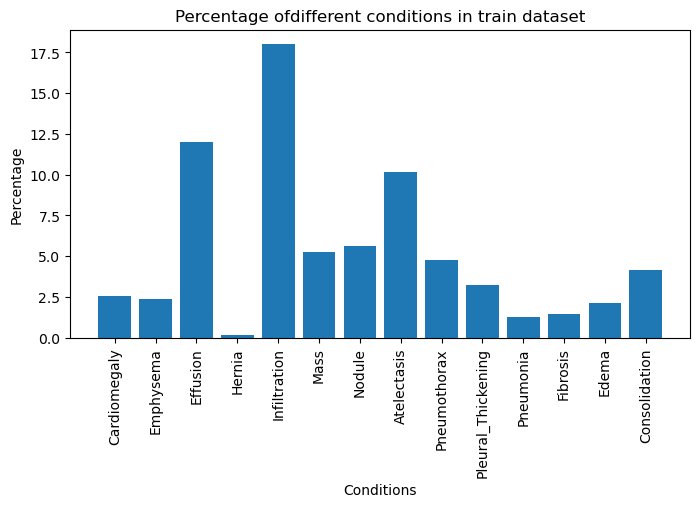

In [40]:
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 


#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

<a name='3-2'></a>
### 3.2 Computing and Visualizing Class Imbalance
Let's take the whole dataset and check the number of the different conditions identified among the x-rays. After that we plot the relative percentage of existance of different conditions in the image.

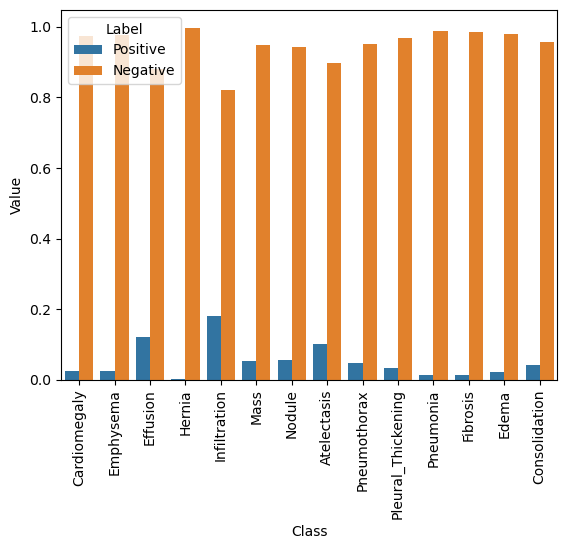

In [41]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
# data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])], ignore_index=True)


plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

Now lets balance the classes  and then use them for visualization 

<a name='3-3'></a>
### 3.3 Dealing with Class Imbalance

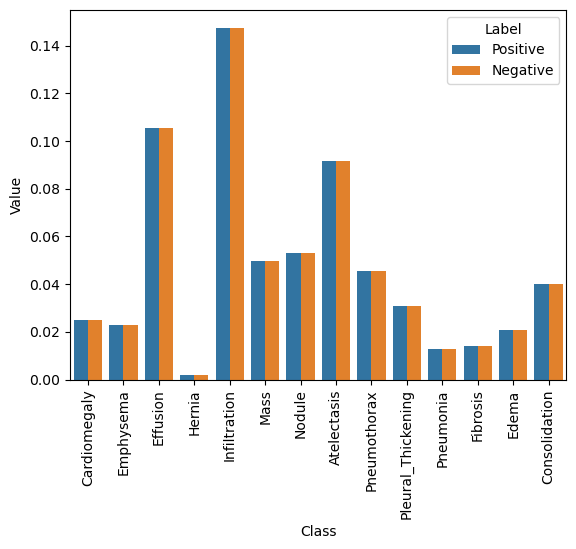

In [42]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


# data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
#                         for l,v in enumerate(neg_contribution)], ignore_index=True)

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = pd.concat([data, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])], ignore_index=True)


plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [43]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        y_true = tf.cast(y_true, dtype=tf.float32)
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

<a name=''>

<a name='4'> </a>
# 4. Model Creation
For the purpose of simplicity, we will use DenseNet121 model from the `keras.application` package. Then we will load the pretrained weights and have a look at the **ROC** curve and **AUROC** values for the different diagonostic categories.

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [45]:
# with strategy.scope():
#     inputs = Input(shape=(224, 224, 3))
#     model = EfficientNetB0(input_tensor=inputs, weights='imagenet', include_top=False)
#     model.trainable = False # Freeze the layer
    
#     # Rebuild top
#     x = GlobalAveragePooling2D(name="avg_pool")(model.output)
#     x = BatchNormalization()(x)

#     x = Dropout(0.2, name="top_dropout")(x)
#     outputs = Dense(len(labels), activation="softmax", name="pred")(x)
    
#     # Compile
#     model = tf.keras.Model(inputs, outputs, name="EfficientNet")

In [46]:
# with strategy.scope():
  
#     def conv_block(x, growth_rate):
#         x1 = BatchNormalization()(x)
#         x1 = ReLU()(x1)
#         x1 = Conv2D(filters=growth_rate, kernel_size=(3, 3), padding='same')(x1)
#         x = Concatenate()([x, x1])
#         return x

#     def dense_block(x, num_layers, growth_rate):
#         for _ in range(num_layers):
#             x = conv_block(x, growth_rate)
#         return x

#     def transition_block(x, reduction):
#         x = BatchNormalization()(x)
#         x = ReLU()(x)
#         x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), kernel_size=(1, 1), padding='same')(x)
#         x = tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
#         return x

#     def CustomNet121(input_shape=(224, 224, 3), num_classes=1000, growth_rate=32, num_blocks=[6, 12, 24, 16], reduction=0.5):
#         inputs = Input(shape=input_shape)
#         x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
#         x = BatchNormalization()(x)
#         x = ReLU()(x)
#         x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

#         num_features = 64
#         for i, num_layers in enumerate(num_blocks):
#             x = dense_block(x, num_layers, growth_rate)
#             num_features += num_layers * growth_rate
#             if i != len(num_blocks) - 1:
#                 x = transition_block(x, reduction)

#         x = BatchNormalization()(x)
#         x = ReLU()(x)
#         x = GlobalAveragePooling2D()(x)
#         x = Dense(num_classes, activation='softmax')(x)

#         model = Model(inputs, x, name='CustomNet-121')
#         return model
#     model = CustomNet121(input_shape = (224,224,3),num_classes=len(labels))

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint

with strategy.scope():
    inputs = Input(shape=(224, 224, 3))
    model = EfficientNetB0(input_tensor=inputs, weights='imagenet', include_top=False)
    model.trainable = True # Freeze the layer
    
    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    x = Dropout(0.2, name="top_dropout")(x)
    outputs = Dense(len(labels), activation="softmax", name="pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")

    # Define the checkpoint callback
    checkpoint = ModelCheckpoint(
        'best_weights.h5',
        monitor='val_accuracy',  # Metric to monitor
        verbose=1,
        save_best_only=True,
        mode='max'  # Mode of the monitored metric (e.g., max for accuracy, min for loss)
    )

    metrics = [
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.AUC(name="AUC"),
        tf.keras.metrics.Precision(name="precision"),
        tfa.metrics.F1Score(average="micro", num_classes=len(labels), name="f1_score_micro"),
        tfa.metrics.F1Score(average="macro", num_classes=len(labels), name="f1_score_macro"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(num_labels=len(labels), multi_label=True),

    ]


    model.compile(
        optimizer=tf.keras.optimizers.Adam( learning_rate=1e-4, amsgrad=False), 
        #loss = 'binary_crossentropy',
        loss = get_weighted_loss(pos_weights, neg_weights),
        metrics = metrics
    )

# model.summary()

In [48]:
weights_path = "/kaggle/input/efficientnetb0-weights/efficent_net_b1_trained_weights.h5"  
model.load_weights(weights_path, by_name=True, skip_mismatch=True)

In [49]:
predicted_vals_before = model.predict_generator(test_generator, steps = len(test_generator))

/tmp/ipykernel_32/720183649.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals_before = model.predict_generator(test_generator, steps = len(test_generator))


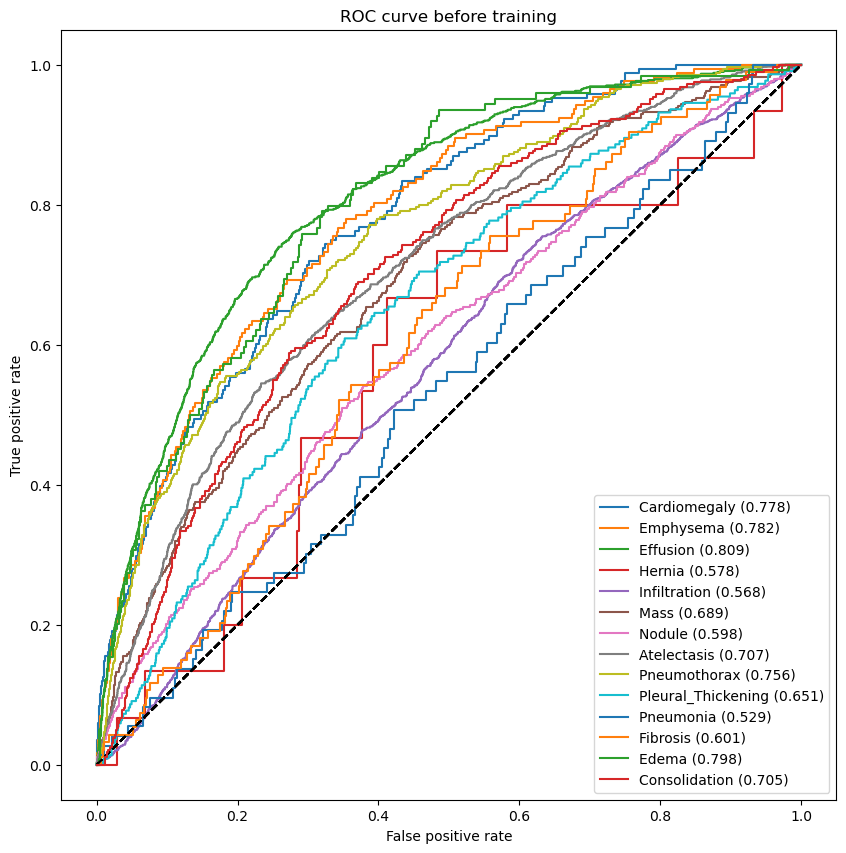

In [50]:
auc_rocs_before =get_roc_curve(labels, predicted_vals_before, test_generator, when = 'before training')

In [51]:
def build_lrfn(lr_start=0.000002, lr_max=0.00010, 
               lr_min=0, lr_rampup_epochs=8, 
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [52]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator), 
                              validation_steps=len(valid_generator), 
                              epochs = EPOCHS,
                              callbacks=[lr_schedule]
                             )

/tmp/ipykernel_32/2700481348.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,



Epoch 1: LearningRateScheduler setting learning rate to 2e-06.
Epoch 1/40


2023-11-18 12:18:00.033406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


336/336 [==============================] - 956s 3s/step - loss: 1.6009 - binary_accuracy: 0.9454 - categorical_accuracy: 0.1953 - AUC: 0.7230 - precision: 0.2118 - f1_score_micro: 0.1796 - f1_score_macro: 0.1411 - recall: 0.0169 - auc_1: 0.7262 - val_loss: 1.6013 - val_binary_accuracy: 0.9479 - val_categorical_accuracy: 0.1877 - val_AUC: 0.7019 - val_precision: 0.2258 - val_f1_score_micro: 0.1444 - val_f1_score_macro: 0.1022 - val_recall: 0.0129 - val_auc_1: 0.6889 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.425e-05.
Epoch 2/40
336/336 [==============================] - 658s 2s/step - loss: 1.5601 - binary_accuracy: 0.9455 - categorical_accuracy: 0.2043 - AUC: 0.7555 - precision: 0.1850 - f1_score_micro: 0.2083 - f1_score_macro: 0.1452 - recall: 0.0129 - auc_1: 0.7168 - val_loss: 1.5926 - val_binary_accuracy: 0.9478 - val_categorical_accuracy: 0.1721 - val_AUC: 0.7185 - val_precision: 0.1420 - val_f1_score_micro: 0.1623 - val_f1_score_macro: 0.1019 - val

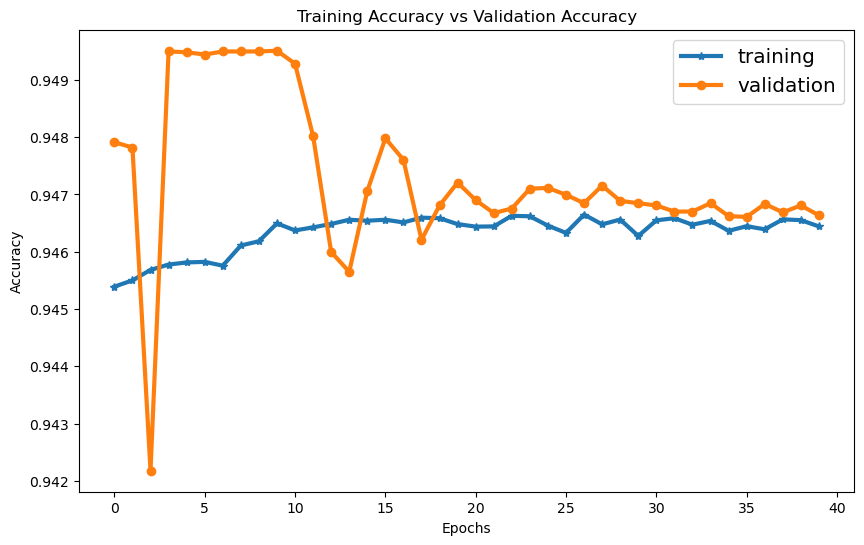

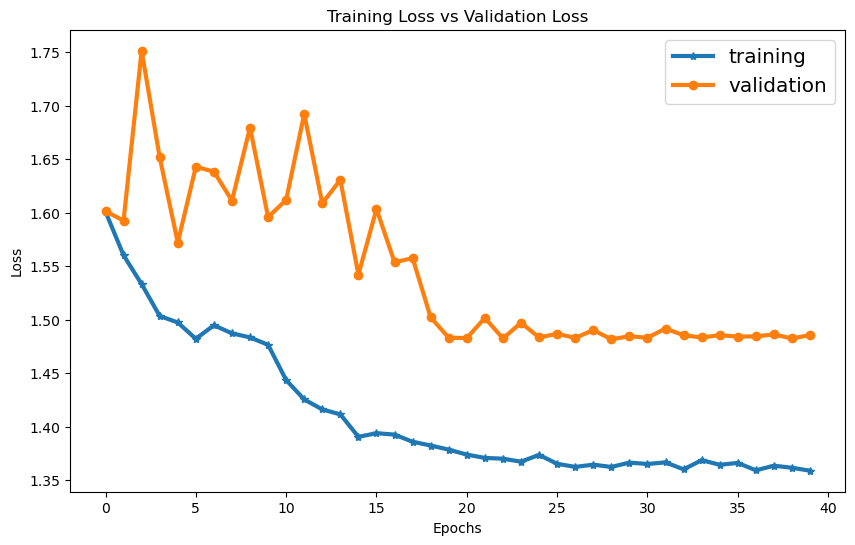

In [53]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['binary_accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_binary_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

/tmp/ipykernel_32/306653748.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals_after = model.predict_generator(test_generator, steps = len(test_generator))


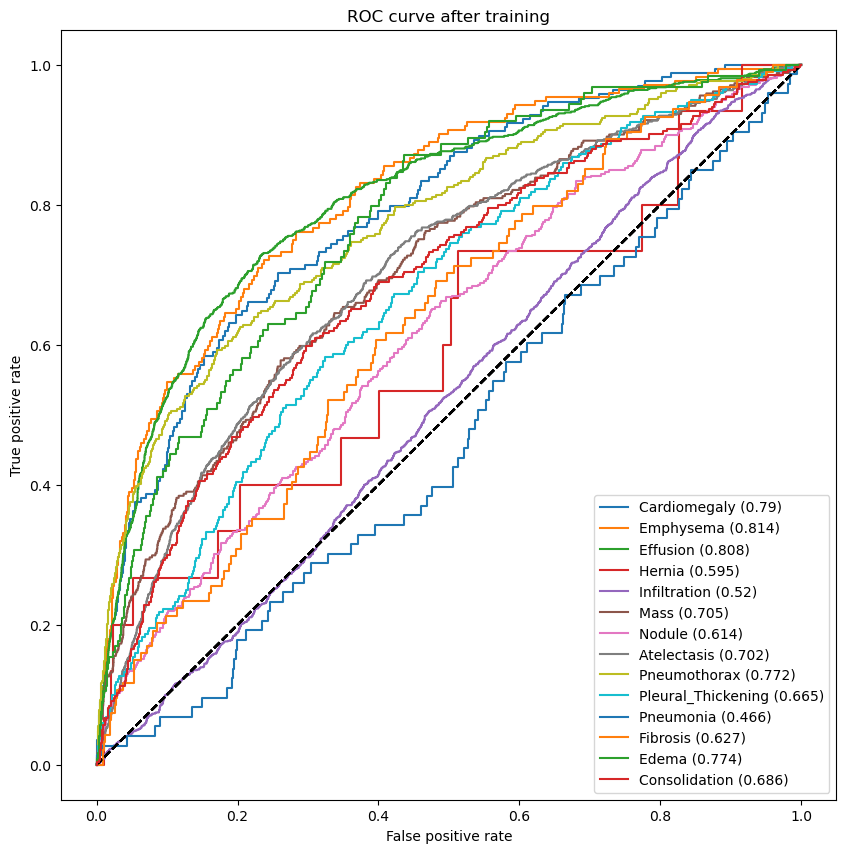

In [54]:
predicted_vals_after = model.predict_generator(test_generator, steps = len(test_generator))
# auc_rocs_before =get_roc_curve(labels, predicted_vals_before, test_generator, when = 'before training')
auc_rocs_after = get_roc_curve(labels, predicted_vals_after, test_generator, when = 'after training')

In [55]:
model.save_weights('efficent_net_b1_trained_weights.h5')
pd.DataFrame.from_dict(history.history).to_csv('efficent_net_b1_training_hisotry.csv', index = False)

In [56]:
len(train_df)

33558